# Self-Attention

You just learned attention: a decoder attends to encoder states. Query looks at keys.

But what if a sequence attends to **itself**?

That's self-attention. And it's the core of Transformers.

## The Twist

Regular attention:
```
Encoder states: "I love cats" 
                   ↓ ↓ ↓
Decoder query: "What should I attend to?"
```

Self-attention:
```
Sequence: "I love cats"
            ↓  ↓  ↓
Each word: "What words should I attend to?"
```

Each word in the sequence generates a query and attends to ALL words (including itself).

**Why?** To understand context.

When processing "bank" in "I deposited money at the bank", self-attention lets "bank" look at "money" and "deposited" to resolve ambiguity.

## Query, Key, Value: The Full Picture

In basic attention, we had decoder state (query) and encoder states (keys/values - same thing).

Self-attention makes this explicit:

**Query (Q):** "What am I looking for?"  
**Key (K):** "What do I contain?"  
**Value (V):** "What information do I pass?"

All three come from the SAME input sequence, just transformed differently.

### Concrete Example

Input: "bank" with embedding x = [0.5, 0.3, 0.8]

```
Q = x · W_Q  →  [0.2, 0.4]  # "I'm looking for financial context"
K = x · W_K  →  [0.1, 0.6]  # "I offer semantic info about bank"
V = x · W_V  →  [0.3, 0.5]  # "Here's my actual representation"
```

W_Q, W_K, W_V are learned weight matrices. Same input, three different projections.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Self-Attention Step by Step

Sentence: "The cat sat"

Each word has an embedding (pretend it's 4-dimensional):

In [3]:
# Word embeddings (seq_len=3, embed_dim=4)
X = np.array([
    [1.0, 0.0, 0.5, 0.2],  # "The"
    [0.8, 0.3, 0.1, 0.9],  # "cat" 
    [0.2, 0.7, 0.4, 0.6],  # "sat"
])

print("Input embeddings:")
print(X)
print(f"Shape: {X.shape} (seq_len, embed_dim)")

Input embeddings:
[[1.  0.  0.5 0.2]
 [0.8 0.3 0.1 0.9]
 [0.2 0.7 0.4 0.6]]
Shape: (3, 4) (seq_len, embed_dim)


### Step 1: Project to Q, K, V

Create three weight matrices (embed_dim × d_k, where d_k is dimension of queries/keys):

In [4]:
embed_dim = 4
d_k = 3  # Query/Key dimension

np.random.seed(42)
W_Q = np.random.randn(embed_dim, d_k) * 0.1
W_K = np.random.randn(embed_dim, d_k) * 0.1
W_V = np.random.randn(embed_dim, d_k) * 0.1

# Project
Q = X @ W_Q  # (3, 3)
K = X @ W_K  # (3, 3)
V = X @ W_V  # (3, 3)

print("Queries (Q):")
print(Q)
print("\nKeys (K):")
print(K)
print("\nValues (V):")
print(V)

Queries (Q):
[[ 0.13948326  0.01527695  0.03198054]
 [ 0.15005056 -0.05211899 -0.00181945]
 [ 0.21226849 -0.01626369 -0.05015858]]

Keys (K):
[[-0.0257205  -0.26059265 -0.12770431]
 [-0.02691175 -0.19149285 -0.24213686]
 [-0.08438842 -0.16160424 -0.03935998]]

Values (V):
[[-0.10567782  0.12015707 -0.14019109]
 [-0.13349073  0.08340647 -0.2108412 ]
 [-0.07211971  0.08361757 -0.11722894]]


Each row is Q/K/V for one word. "cat" has a query asking "what should I look at?", a key saying "here's what I am", and a value with its information.

### Step 2: Compute Attention Scores

Every query attends to every key.

**Score matrix:** Q · K^T

```
        K_The  K_cat  K_sat
Q_The [  ?      ?      ?   ]  ← How much "The" attends to each word
Q_cat [  ?      ?      ?   ]  ← How much "cat" attends to each word  
Q_sat [  ?      ?      ?   ]  ← How much "sat" attends to each word
```

In [5]:
# Scaled dot product
scores = (Q @ K.T) / np.sqrt(d_k)

print("Attention scores (scaled):")
print(scores)
print(f"\nShape: {scores.shape}")
print("Each row shows how one word scores all words (including itself)")

Attention scores (scaled):
[[-0.00672769 -0.00832703 -0.00894797]
 [ 0.00574741  0.00368514 -0.00240655]
 [ 0.00299299  0.00551202 -0.00768481]]

Shape: (3, 3)
Each row shows how one word scores all words (including itself)


Notice the diagonal: each word also attends to itself. "cat" can look at "cat".

### Step 3: Softmax to Get Attention Weights

Convert each row to probabilities:

In [6]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # Numerical stability
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

attention_weights = softmax(scores)

print("Attention weights:")
print(attention_weights)
print(f"\nEach row sums to 1: {attention_weights.sum(axis=1)}")

Attention weights:
[[0.33375786 0.33322449 0.33301764]
 [0.3344684  0.33377935 0.33175225]
 [0.33423563 0.33507865 0.33068572]]

Each row sums to 1: [1. 1. 1.]


### Step 4: Weighted Sum of Values

Each word's new representation is a weighted combination of all value vectors:

In [7]:
output = attention_weights @ V

print("Self-attention output:")
print(output)
print(f"\nShape: {output.shape} (same as input: seq_len × d_k)")

Self-attention output:
[[-0.10377032  0.09574257 -0.15608664]
 [-0.10382822  0.09576841 -0.15615489]
 [-0.10390015  0.09575964 -0.15627118]]

Shape: (3, 3) (same as input: seq_len × d_k)


Each word now has a context-aware representation. "cat" doesn't just encode "cat" - it encodes "cat in the context of 'The' and 'sat'".

## Implementation: Self-Attention Layer

In [8]:
class SelfAttention:
    def __init__(self, embed_dim, d_k):
        self.d_k = d_k
        self.W_Q = np.random.randn(embed_dim, d_k) * 0.1
        self.W_K = np.random.randn(embed_dim, d_k) * 0.1
        self.W_V = np.random.randn(embed_dim, d_k) * 0.1
    
    def forward(self, X):
        """
        Args:
            X: (seq_len, embed_dim)
        Returns:
            output: (seq_len, d_k)
            attention_weights: (seq_len, seq_len)
        """
        # Project to Q, K, V
        Q = X @ self.W_Q
        K = X @ self.W_K
        V = X @ self.W_V
        
        # Scaled dot-product attention
        scores = (Q @ K.T) / np.sqrt(self.d_k)
        attention_weights = softmax(scores)
        output = attention_weights @ V
        
        return output, attention_weights

That's it. Four lines of actual computation:
1. Project to Q, K, V
2. Compute scores (Q·K^T / √d_k)
3. Apply softmax
4. Weighted sum of values

Everything else in Transformers builds on this.

## Visualizing Self-Attention

In [9]:
def visualize_self_attention(attention_weights, words):
    fig, ax = plt.subplots(figsize=(8, 7))
    
    im = ax.imshow(attention_weights, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    
    ax.set_xticks(np.arange(len(words)))
    ax.set_yticks(np.arange(len(words)))
    ax.set_xticklabels(words, fontsize=11)
    ax.set_yticklabels(words, fontsize=11)
    
    ax.set_xlabel('Attending to', fontsize=12, fontweight='bold')
    ax.set_ylabel('Word', fontsize=12, fontweight='bold')
    ax.set_title('Self-Attention Weights', fontsize=14, fontweight='bold')
    
    # Annotations
    for i in range(len(words)):
        for j in range(len(words)):
            text = ax.text(j, i, f'{attention_weights[i, j]:.2f}',
                          ha="center", va="center", 
                          color="white" if attention_weights[i, j] > 0.5 else "black",
                          fontsize=10)
    
    plt.colorbar(im, ax=ax, label='Attention Weight')
    plt.tight_layout()
    plt.show()

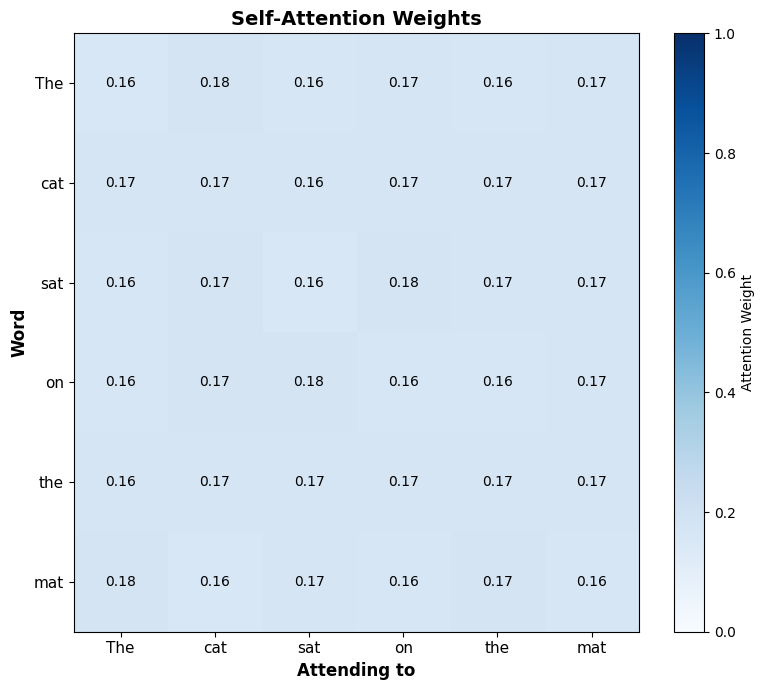

In [10]:
# Example: longer sentence
sentence = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(sentence)

# Random embeddings
np.random.seed(123)
X = np.random.randn(seq_len, 8) * 0.5

# Self-attention
attn = SelfAttention(embed_dim=8, d_k=8)
output, weights = attn.forward(X)

visualize_self_attention(weights, sentence)

Each row shows what one word attends to. Notice words don't just attend to neighbors - long-range dependencies are possible.

## Multi-Head Attention

One self-attention head learns ONE pattern of relationships.

But language has multiple types of relationships:
- Syntactic (subject-verb)
- Semantic (synonyms, antonyms)
- Positional (next word, previous word)
- Anaphoric (pronoun resolution)

**Solution:** Multiple attention heads running in parallel, each learning different patterns.

### The Mechanism

Instead of one set of W_Q, W_K, W_V:

```
Head 1: W_Q1, W_K1, W_V1 → output1
Head 2: W_Q2, W_K2, W_V2 → output2
Head 3: W_Q3, W_K3, W_V3 → output3
...
Head h: W_Qh, W_Kh, W_Vh → outputh

Concatenate all outputs → final output
```

Each head has smaller dimensions (d_k / h), so total parameters stay reasonable.

In [11]:
class MultiHeadAttention:
    def __init__(self, embed_dim, num_heads):
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads  # Dimension per head
        self.embed_dim = embed_dim
        
        # Each head has its own Q, K, V projections
        self.heads = [SelfAttention(embed_dim, self.d_k) for _ in range(num_heads)]
        
        # Output projection
        self.W_O = np.random.randn(embed_dim, embed_dim) * 0.1
    
    def forward(self, X):
        """
        Args:
            X: (seq_len, embed_dim)
        Returns:
            output: (seq_len, embed_dim)
            attention_weights: list of (seq_len, seq_len) for each head
        """
        # Run each head
        head_outputs = []
        attention_weights = []
        
        for head in self.heads:
            output, weights = head.forward(X)
            head_outputs.append(output)
            attention_weights.append(weights)
        
        # Concatenate heads
        concat = np.concatenate(head_outputs, axis=-1)  # (seq_len, embed_dim)
        
        # Final linear projection
        output = concat @ self.W_O
        
        return output, attention_weights

### Why Multiple Heads Work

Different heads specialize. Let's see this in action:

In [12]:
sentence = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(sentence)

np.random.seed(42)
X = np.random.randn(seq_len, 8) * 0.5

mha = MultiHeadAttention(embed_dim=8, num_heads=4)
output, all_weights = mha.forward(X)

print(f"Output shape: {output.shape}")
print(f"Number of attention heads: {len(all_weights)}")

Output shape: (6, 8)
Number of attention heads: 4


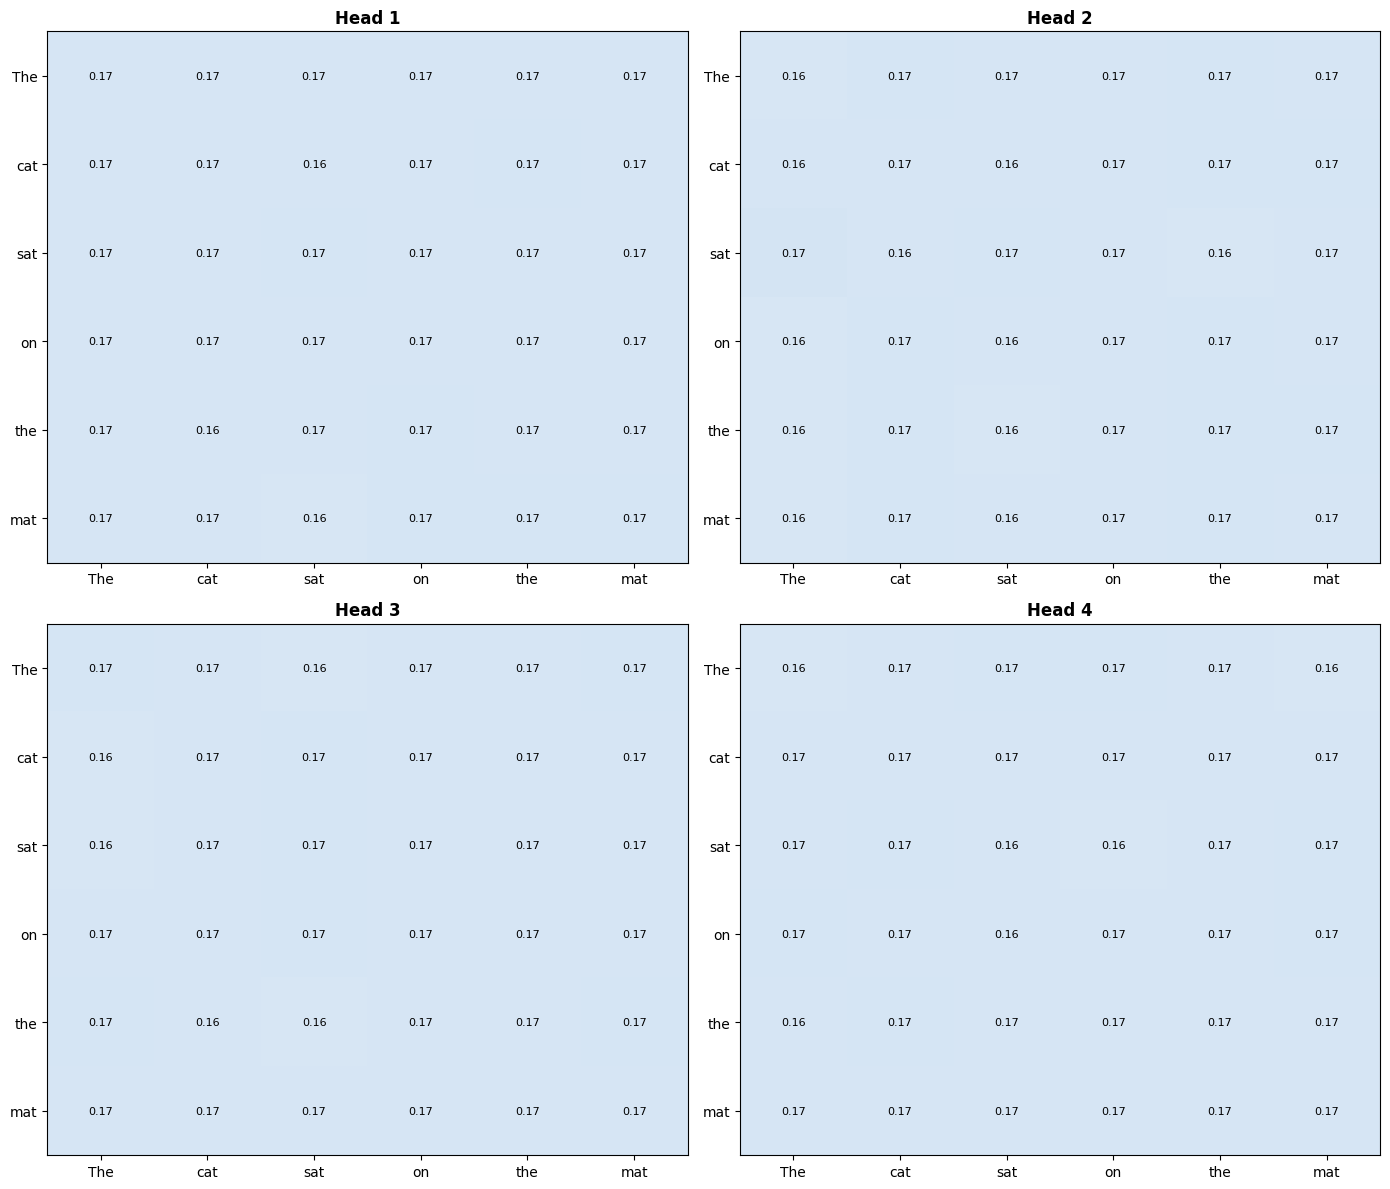

In [13]:
# Visualize each head
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (ax, weights) in enumerate(zip(axes, all_weights)):
    im = ax.imshow(weights, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(sentence)))
    ax.set_yticks(np.arange(len(sentence)))
    ax.set_xticklabels(sentence, fontsize=10)
    ax.set_yticklabels(sentence, fontsize=10)
    ax.set_title(f'Head {i+1}', fontsize=12, fontweight='bold')
    
    # Add values
    for row in range(len(sentence)):
        for col in range(len(sentence)):
            color = 'white' if weights[row, col] > 0.5 else 'black'
            ax.text(col, row, f'{weights[row, col]:.2f}',
                   ha='center', va='center', color=color, fontsize=8)

plt.tight_layout()
plt.show()

Each head learns different patterns. Some focus on adjacent words, others on long-range dependencies. The model learns this automatically.

## Comparison: Single Head vs Multi-Head

**Single head (d_k = 64):**
- One pattern of attention
- Total params: 3 × (512 × 64) = 98K

**Multi-head (8 heads, d_k = 8 each):**
- Eight different patterns
- Total params: 8 × 3 × (512 × 8) + (64 × 512) = 131K
- More expressive for similar parameter count

You get richer representations without massive parameter increase.

## Masked Self-Attention (Preview)

In decoder models (like GPT), you can't attend to future tokens. During training on "The cat sat", when predicting "sat", you can't look at "sat" itself.

**Solution:** Mask out future positions before softmax.

In [14]:
def masked_self_attention(X, W_Q, W_K, W_V, d_k):
    seq_len = X.shape[0]
    
    Q = X @ W_Q
    K = X @ W_K
    V = X @ W_V
    
    scores = (Q @ K.T) / np.sqrt(d_k)
    
    # Create mask: upper triangle is -inf
    mask = np.triu(np.ones((seq_len, seq_len)) * -1e9, k=1)
    scores = scores + mask
    
    attention_weights = softmax(scores)
    output = attention_weights @ V
    
    return output, attention_weights

Masked attention weights:
[[1.         0.         0.        ]
 [0.49957648 0.50042352 0.        ]
 [0.33296717 0.33190417 0.33512866]]

Notice the zero upper triangle - future tokens are blocked


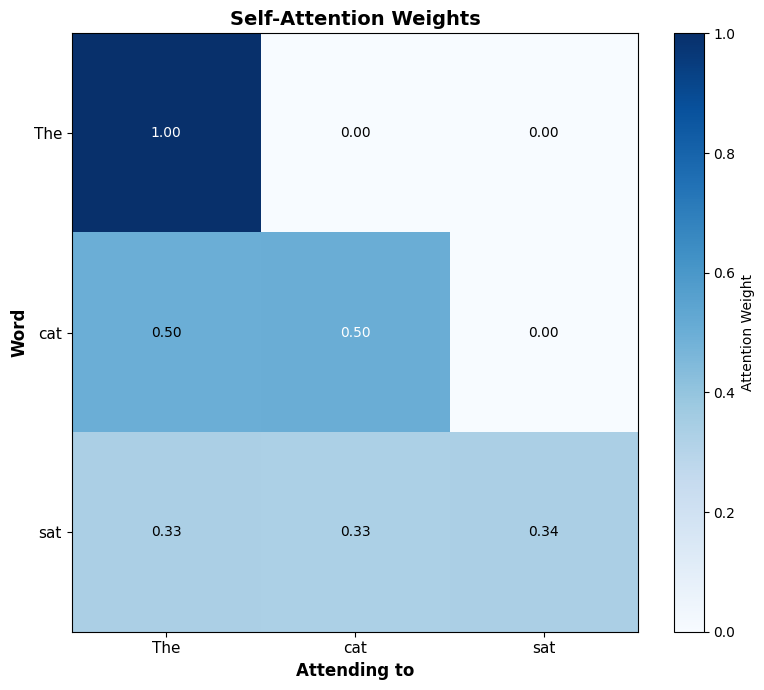

In [15]:
# Demo masked attention
sentence = ["The", "cat", "sat"]
seq_len = len(sentence)

np.random.seed(42)
X = np.random.randn(seq_len, 4) * 0.5
W_Q = np.random.randn(4, 4) * 0.1
W_K = np.random.randn(4, 4) * 0.1
W_V = np.random.randn(4, 4) * 0.1

output, weights = masked_self_attention(X, W_Q, W_K, W_V, d_k=4)

print("Masked attention weights:")
print(weights)
print("\nNotice the zero upper triangle - future tokens are blocked")

visualize_self_attention(weights, sentence)

The upper triangle is zero. "The" only sees "The", "cat" sees "The" and "cat", "sat" sees all three. This is causal/autoregressive attention.

## Computational Complexity

Self-attention computes scores for ALL pairs of tokens.

**Complexity:** O(n² · d) where n = sequence length, d = dimension

For a 512-token sequence with d=512:
- Pairs: 512² = 262,144 computations
- Each pair: 512-dimensional dot product
- Total: ~134M operations

This is why long sequences are expensive. RNNs were O(n · d²) - better for very long sequences but worse for parallelization.

Modern techniques (sparse attention, linear attention) reduce this, but standard Transformers are quadratic.

## Key Takeaways

**Self-attention:**
- Sequence attends to itself
- Each token looks at all others (including itself)
- Q, K, V all derived from same input via different projections

**Multi-head attention:**
- Multiple heads learn different relationship patterns
- Heads run in parallel, outputs concatenated
- More expressive than single head

**Masked attention:**
- Prevents attending to future tokens
- Essential for autoregressive generation
- Upper triangle of attention matrix zeroed out

**The formula:**
```
Attention(Q, K, V) = softmax(Q·K^T / √d_k) · V
```

This is the engine of every Transformer model. GPT, BERT, T5 - all built on this.

Next: The full Transformer architecture.